In [3]:
import os
os.chdir('..')

In [4]:
from model import FCN
from argparse import ArgumentParser
from data import TGSTransform, TGSSaltDataset, collate_fn
import matplotlib.pyplot as plt
from train import LitUNet
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
from utils import calculate_mAP
import pandas as pd
import os

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [5]:
p = torch.load('logs/iter01/16/ckpt/epoch=78-step=15799.ckpt')
m = FCN(1, 1, True, 16)
s = { k[6:]:v for k,v in p['state_dict'].items()}
m.load_state_dict(s)

<All keys matched successfully>

In [6]:
root_ds = 'dataset'
img_size_ori = 101
val_df = pd.read_csv('val.csv')
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment=False, use_depth=False))
print(len(val_ds))
val_dl = DataLoader(val_ds, batch_size=8, num_workers=4, collate_fn=collate_fn)
val_iter = iter(val_dl)

800


In [7]:
batch = next(val_iter)

In [8]:
m.eval()
m.cuda()
with torch.no_grad():
    x1 = m.inc(batch[0].cuda())
    x2 = m.down1(x1)
    x3 = m.down2(x2)
    x4 = m.down3(x3)
    x5 = m.down4(x4)
    y1 = m.up1(x5)
    y2 = m.up2(y1)
    y3 = m.up3(y2)
    y4 = m.up4(y3)
    logits = m.outc(y4)

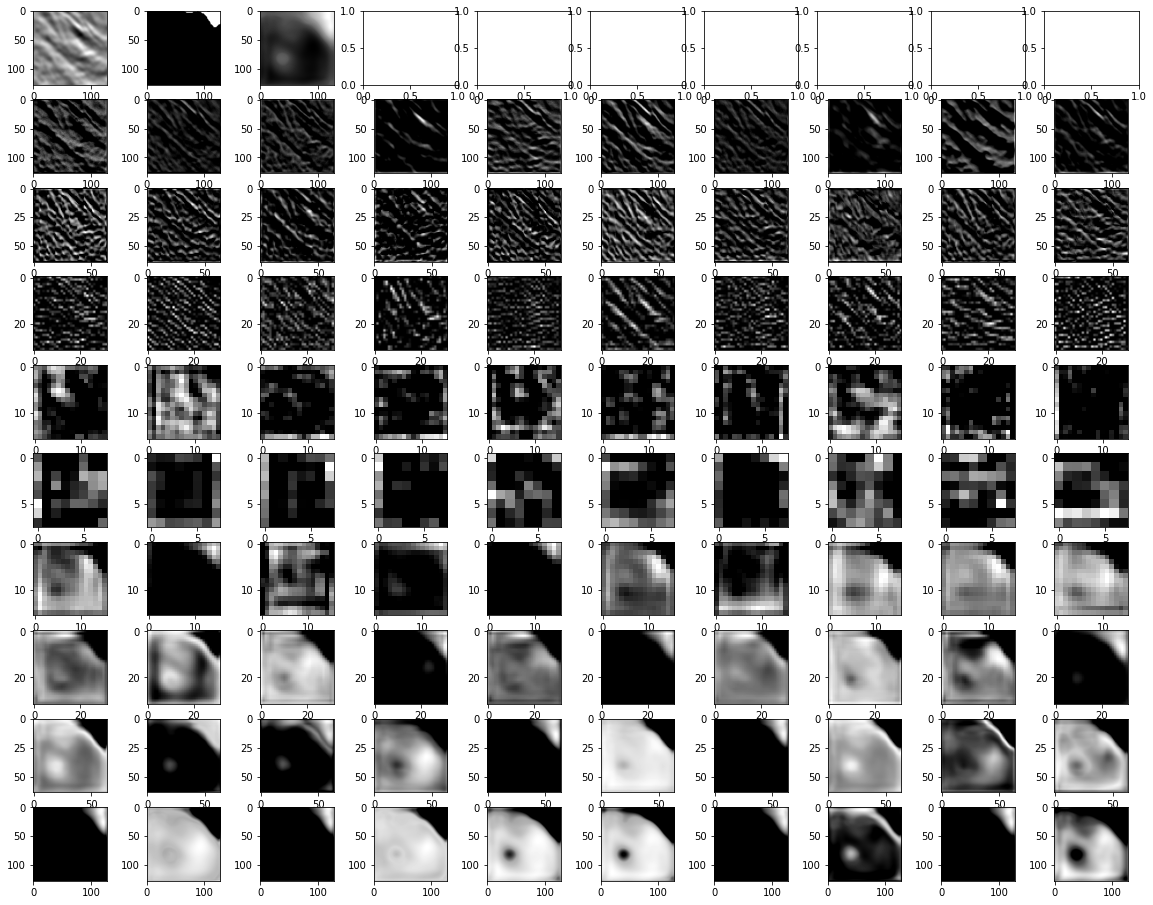

In [11]:
idx = 5
img = batch[0][idx]
mask = batch[1][idx]
_img = img.squeeze(0)
_msk = mask.squeeze(0).round()
inside = [fm[idx] for fm in [x1, x2, x3, x4, x5, y1, y2, y3, y4]]
fig, axs = plt.subplots(nrows=len(inside) + 1, ncols=10, figsize=(20, 16))
axs[0, 0].imshow(_img, cmap='gray')
axs[0, 1].imshow(_msk, cmap='gray')
axs[0, 2].imshow(logits[idx].squeeze().cpu().numpy(), cmap='gray')

for i, fm in enumerate(inside):
    for j in range(10):
        _att = fm[j].squeeze().cpu().numpy()
        axs[i + 1, j].imshow(_att, cmap='gray')
# plt.show()
plt.savefig('experiments/fcn.png')